使用了两个网络vgg&resnet进行特征提取，然后将输出的特征在channel维进行concat，再将concat后的结果输入到全连接层，最终得到预测结果。

In [1]:
import torch
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import torch.nn as nn

# 使用VGG特征
model = models.vgg16(pretrained=True)
vgg_feature = model.features

# 使用Resnet特征
resnet = models.resnet34(pretrained=True)
modules = list(resnet.children())[:-2]      # delete the last fc layer.
res_feature = nn.Sequential(*modules).eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [3]:
# !unzip ../input/dogs-vs-cats/train.zip > /dev/null

将VGG，Resnet特征concat起来进行训练。

In [4]:
root_dir = "./train"
import os 
from PIL import Image
imgs_name = os.listdir(root_dir)

imgs_path = []
labels_data = []

for name in imgs_name:
    if name[:3] == "dog":
        label = 0
    if name[:3] == "cat":
        label = 1
    img_path = os.path.join(root_dir,name)
    imgs_path.append(img_path)
    labels_data.append(label)


In [5]:
from sklearn.model_selection import train_test_split
train_imgs_path,valid_imgs_path,train_labels,valid_labels = train_test_split(imgs_path,labels_data,test_size=0.2,shuffle=True)

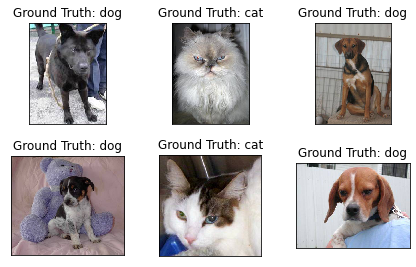

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  img = Image.open(train_imgs_path[i])
  plt.imshow(img, interpolation='none')
  plt.title("Ground Truth: {}".format("cat" if train_labels[i]==1 else "dog"))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [7]:
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision
from torchvision import datasets,transforms
import os 
from PIL import Image

my_transforms = transforms.Compose([
    transforms.Resize(75),
    transforms.RandomResizedCrop(64), #随机裁剪一个area然后再resize
    transforms.RandomHorizontalFlip(), #随机水平翻转
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class CatDogDataset(Dataset):
    def __init__(self,imgs_path,labels,my_transforms):
        self.my_transforms = my_transforms
        self.imgs_path = imgs_path
        self.labels = labels
        self.len = len(self.imgs_path)

    def __getitem__(self,index):
        img = Image.open(self.imgs_path[index])
        return my_transforms(img),self.labels[index]

    def __len__(self):
        return self.len
    
train_dataset = CatDogDataset(train_imgs_path,train_labels,my_transforms)
valid_dataset = CatDogDataset(valid_imgs_path,valid_labels,valid_transforms)

train_loader = DataLoader(train_dataset,1024,shuffle=True,num_workers=2)
valid_loader = DataLoader(valid_dataset,512,num_workers=2)

In [8]:
import torch.nn.functional as F
class MyNet(nn.Module):
    def __init__(self,resnet_feature,vgg_feature):
        super(MyNet,self).__init__()
        self.resnet_feature=resnet_feature
        self.vgg_feature = vgg_feature

        self.fc = nn.Sequential(
            nn.Linear(1024*2*2,256),
            nn.Dropout(0.25),
            nn.Linear(256,2)
        )
    def forward(self,x):
        x1 = self.resnet_feature(x)
        x2 = self.vgg_feature(x)
        x = torch.cat((x1,x2),1)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x,dim=1)
my_net = MyNet(res_feature,vgg_feature).to(device)

In [9]:
# a = torch.rand(16,3,64,64).to(device)

# b = my_net(a)

In [10]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
log_writer = SummaryWriter()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.parameters(),lr=0.01,momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,50)


In [11]:
def train_loss_acc():
    correct = 0
    total = 0
    losses = 0
    for i,data in enumerate(train_loader):
        train_imgs,train_labels = data
        train_imgs = train_imgs.to(device)
        train_labels = train_labels.to(device)
        outputs = my_net(train_imgs)
        _,predict_label = torch.max(outputs,1)
        total += train_labels.size(0)
        correct += (predict_label == train_labels).sum().item()
        loss = criterion(outputs,train_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()

    return losses/(i+1),correct/total


def valid_loss_acc():
    losses = 0
    correct = 0
    total = 0
    for i,data in enumerate(valid_loader):
        valid_imgs,valid_labels = data
        valid_imgs = valid_imgs.to(device)
        valid_labels = valid_labels.to(device)
        outputs = my_net(valid_imgs)
        loss = criterion(outputs,valid_labels)
        losses += loss.item()
        _,predict_label = torch.max(outputs,1)
        total += valid_labels.size(0)
        correct += (predict_label == valid_labels).sum().item()
    return losses/(i+1),correct/total

for epoch in range(0,100):
    
    my_net.train()
    train_loss,train_acc = train_loss_acc()

    log_writer.add_scalar("Loss/train",float(train_loss),epoch)
    log_writer.add_scalar("Acc/train",float(train_acc),epoch)

    my_net.eval()
    valid_loss,valid_acc = valid_loss_acc()
    log_writer.add_scalar("Loss/valid",float(valid_loss),epoch)
    log_writer.add_scalar("Acc/valid",float(valid_acc),epoch)
    
    scheduler.step()
    # if epoch % 20 == 1:
    print("epoch:{} 训练集准确率：{}，loss：{:.3}, 验证集：{}，loss：{:.3}".format(epoch,train_acc,train_loss,valid_acc,valid_loss))
        

epoch:0 训练集准确率：0.827，loss：0.361, 验证集：0.903，loss：0.224
epoch:1 训练集准确率：0.90495，loss：0.218, 验证集：0.9188，loss：0.202
epoch:2 训练集准确率：0.91795，loss：0.188, 验证集：0.9244，loss：0.176
epoch:3 训练集准确率：0.92795，loss：0.166, 验证集：0.9306，loss：0.161
epoch:4 训练集准确率：0.93205，loss：0.158, 验证集：0.9256，loss：0.174
epoch:5 训练集准确率：0.9318，loss：0.158, 验证集：0.9352，loss：0.149
epoch:6 训练集准确率：0.93265，loss：0.154, 验证集：0.9252，loss：0.167
epoch:7 训练集准确率：0.9381，loss：0.146, 验证集：0.94，loss：0.142
epoch:8 训练集准确率：0.9432，loss：0.136, 验证集：0.938，loss：0.145
epoch:9 训练集准确率：0.9443，loss：0.13, 验证集：0.9328，loss：0.158
epoch:10 训练集准确率：0.946，loss：0.13, 验证集：0.9394，loss：0.142
epoch:11 训练集准确率：0.9464，loss：0.126, 验证集：0.9438，loss：0.141
epoch:12 训练集准确率：0.94835，loss：0.121, 验证集：0.9446，loss：0.132
epoch:13 训练集准确率：0.94925，loss：0.119, 验证集：0.9428，loss：0.134
epoch:14 训练集准确率：0.9493，loss：0.12, 验证集：0.9442，loss：0.134
epoch:15 训练集准确率：0.9488，loss：0.119, 验证集：0.9416，loss：0.135
epoch:16 训练集准确率：0.954，loss：0.111, 验证集：0.9426，loss：0.134
epoch:17 训练集准确率：0.9525，loss：0.112, 验证集：0.943

In [12]:
torch.save(my_net,"猫狗分类使用resnet做特征提取.h5")

In [13]:
my_net.eval()
valid_loss,valid_acc = valid_loss_acc()
print("最终准确率为：{}".format(valid_acc))

最终准确率为：0.9488
